In [1]:
!pip install langgraph langchain-core langchain typing_extensions pydantic rich google-generativeai graphviz langchain-google-genai

In [2]:
!pip install google-genai

In [33]:
# Imports & Setup
import os, json, operator, getpass
from datetime import datetime
from typing_extensions import Optional, Annotated, Sequence, Literal
from pydantic import BaseModel, Field

from rich.console import Console
from rich.panel import Panel
from rich.text import Text
from rich.markdown import Markdown

console = Console()

from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, get_buffer_string
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.types import Command
from langgraph.checkpoint.memory import InMemorySaver
from langchain_google_genai import ChatGoogleGenerativeAI
from IPython.display import Image, display

import google.generativeai as genai
from getpass import getpass

# Enter API key securely
os.environ["GOOGLE_API_KEY"] = getpass("Enter your Google API Key: ")

# Configure the library
genai.configure(api_key=os.environ["GOOGLE_API_KEY"])

# Initialize the model
model = genai.GenerativeModel("models/gemini-2.5-flash"
)

Enter your Google API Key: ··········


In [34]:
# UI Helper Functions
def show_prompt(prompt_text: str, title: str = "Prompt", border_style: str = "blue"):
    """Nicely display prompts with highlighting."""
    formatted_text = Text(prompt_text)
    formatted_text.highlight_regex(r'<[^>]+>', style="bold blue")
    formatted_text.highlight_regex(r'##[^#\n]+', style="bold magenta")
    formatted_text.highlight_regex(r'###[^#\n]+', style="bold cyan")
    console.print(Panel(formatted_text, title=f"[bold green]{title}[/bold green]", border_style=border_style, padding=(1,2)))

def format_message_content(message):
    parts, tool_calls_processed = [], False
    if isinstance(message.content, str):
        parts.append(message.content)
    elif isinstance(message.content, list):
        for item in message.content:
            if item.get('type') == 'text':
                parts.append(item['text'])
            elif item.get('type') == 'tool_use':
                parts.append(f"\n Tool Call: {item['name']}")
                parts.append(f"   Args: {json.dumps(item['input'], indent=2)}")
                parts.append(f"   ID: {item.get('id', 'N/A')}")
                tool_calls_processed = True
    else:
        parts.append(str(message.content))
    if not tool_calls_processed and hasattr(message, 'tool_calls') and message.tool_calls:
        for tool_call in message.tool_calls:
            parts.append(f"\n Tool Call: {tool_call['name']}")
            parts.append(f"   Args: {json.dumps(tool_call['args'], indent=2)}")
            parts.append(f"   ID: {tool_call['id']}")
    return "\n".join(parts)

def format_messages(messages):
    for m in messages:
        msg_type = m.__class__.__name__.replace('Message','')
        content = format_message_content(m)
        if msg_type == 'Human':
            console.print(Panel(content, title="Human", border_style="blue"))
        elif msg_type == 'Ai':
            console.print(Panel(content, title="Assistant", border_style="green"))
        elif msg_type == 'Tool':
            console.print(Panel(content, title="Tool Output", border_style="yellow"))
        else:
            console.print(Panel(content, title=f"{msg_type}", border_style="white"))

In [35]:
# Prompt Templates
clarify_with_user_instructions = """
These are the messages that have been exchanged so far from the user asking for the report:
<Messages>
{messages}
</Messages>

Today's date is {date}.

Assess whether you need to ask a clarifying question, or if the user has already provided enough information for you to start research.

Return JSON with:
- "{{\"need_clarification\"}}": true/false
- "{{\"question\"}}": string (if clarification needed)
- "{{\"verification\"}}": string (if enough info)
"""

In [36]:
# State & Schemas
class AgentInputState(MessagesState): pass

class AgentState(MessagesState):
    research_brief: Optional[str]
    supervisor_messages: Annotated[Sequence[BaseMessage], add_messages]
    raw_notes: Annotated[list[str], operator.add] = []
    notes: Annotated[list[str], operator.add] = []
    final_report: str

class ClarifyWithUser(BaseModel):
    need_clarification: bool
    question: str
    verification: str

class ResearchQuestion(BaseModel):
    research_brief: str


In [37]:
# Utilities
def get_today_str() -> str:
    dt = datetime.now()
    return f"{dt.strftime('%a %b')} {dt.day}, {dt.strftime('%Y')}"

In [38]:
# Workflow Nodes
def clarify_with_user(state: AgentState) -> Command[Literal["write_research_brief", "__end__"]]:
    import re, json

    prompt = f"""
    These are the messages that have been exchanged so far from the user asking for the report:
    <Messages>
    {get_buffer_string(messages=state['messages'])}
    </Messages>

    Today's date is {get_today_str()}.

    Assess whether you need to ask a clarifying question, or if the user has already provided enough information for you to start research.

    Return JSON with:
    {{
      "need_clarification": true/false,
      "question": "...",
      "verification": "..."
    }}
    """

    response = model.generate_content(contents=prompt)
    output_text = response.text

    match = re.search(r"\{.*\}", output_text, re.DOTALL)
    if match:
        try:
            parsed = json.loads(match.group())
        except json.JSONDecodeError:
            return Command(goto=END, update={"messages":[AIMessage(content="Clarification step failed (JSON decode error).")]})
    else:
        return Command(goto=END, update={"messages":[AIMessage(content="Clarification step failed (No JSON found).")]})

    if parsed.get("need_clarification"):
        # Stay in clarify_with_user until enough info is gathered
        return Command(update={"messages":[AIMessage(content=parsed.get("question", "Need clarification"))]})
    else:
        # When enough info is provided, move to write_research_brief
        return Command(goto="write_research_brief", update={"messages":[AIMessage(content=parsed.get("verification", "Proceeding with research brief"))]})


def write_research_brief(state: AgentState) -> Command[Literal["__end__"]]:
    import re, json

    user_topic = state['messages'][-1].content  # last user input

    prompt = f"""
    You are a research assistant. Write a research brief about the following topic: {user_topic}.
    Return only valid JSON in the format:
    {{
      "title": "...",
      "date": "{get_today_str()}",
      "problem_statement": "...",
      "key_questions": ["...", "...", "..."],
      }}
    """

    response = model.generate_content(contents=prompt)
    output_text = response.text

    match = re.search(r"\{.*\}", output_text, re.DOTALL)
    if match:
        try:
            parsed = json.loads(match.group())

            # Always make sure date is included at the top
            parsed = {
                "title": parsed.get("title", ""),
                "date": get_today_str(),
                "problem_statement": parsed.get("problem_statement", ""),
                "key_questions": parsed.get("key_questions", []),

            }

            return Command(
                goto=END,
                update={
                    "research_brief": json.dumps(parsed, indent=2),
                    "messages": [AIMessage(content="Research brief generated successfully ")]
                }
            )
        except json.JSONDecodeError:
            return Command(goto=END, update={"messages":[AIMessage(content="Error: Failed to parse JSON")]})
    else:
        return Command(goto=END, update={"messages":[AIMessage(content="Error: No JSON found in response")]})

In [39]:
# Graph Build
deep_researcher_builder = StateGraph(AgentState, input_schema=AgentInputState)
deep_researcher_builder.add_node("clarify_with_user", clarify_with_user)
deep_researcher_builder.add_node("write_research_brief", write_research_brief)
deep_researcher_builder.add_edge(START, "clarify_with_user")
deep_researcher_builder.add_edge("write_research_brief", END)

checkpointer = InMemorySaver()
scope = deep_researcher_builder.compile(checkpointer=checkpointer)

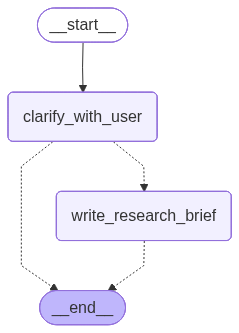

In [40]:
# Visualize workflow
display(Image(scope.get_graph(xray=True).draw_mermaid_png()))

In [41]:
# Interactive Demo with Rich Panel
import json
from IPython.display import display, Markdown
from datetime import datetime

# Interactive Demo
while True:
    user_topic = input("\nEnter your research topic (or type 'exit' to quit): ")
    if user_topic.lower() == "exit":
        break

    thread = {"configurable": {"thread_id": "1"}}
    result = scope.invoke({"messages":[HumanMessage(content=user_topic)]}, config=thread)

    format_messages(result['messages'])

    if "research_brief" in result:
        # Parse JSON
        brief_json = json.loads(result["research_brief"])

        # Extract fields
        title = brief_json.get("title", "Untitled")
        problem = brief_json.get("problem_statement", "N/A")
        questions = brief_json.get("key_questions", [])


        # Today’s date
        today = datetime.today().strftime("%Y-%m-%d")

         # -------- View 1: Clean Markdown Report (No Sources) --------
        md_output = f"""
### Research Brief: {title}

**Date:** {today}

**Problem Statement**
{problem}

**Key Questions**
"""
        for q in questions:
            md_output += f"- {q}\n"

        display(Markdown(md_output))

        # -------- View 2: Pretty JSON (No Sources) --------
        formatted_json = json.dumps(brief_json, indent=2)
        display(Markdown(f"### Raw JSON Research Brief\n```json\n{formatted_json}\n```"))


Enter your research topic (or type 'exit' to quit): Role of Satellites


╭───────────────────────────────────────────────────── Human ─────────────────────────────────────────────────────╮
│ Role of Satellites                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────── AI ───────────────────────────────────────────────────────╮
│ To provide you with the most relevant information, could you please specify which aspects of the 'Role of       │
│ Satellites' you're most interested in? For example, are you looking for their role in communication,            │
│ navigation, Earth observation, scientific research, military applications, or something else?                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯


Enter your research topic (or type 'exit' to quit): role in Earth observation


╭───────────────────────────────────────────────────── Human ─────────────────────────────────────────────────────╮
│ Role of Satellites                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────── AI ───────────────────────────────────────────────────────╮
│ To provide you with the most relevant information, could you please specify which aspects of the 'Role of       │
│ Satellites' you're most interested in? For example, are you looking for their role in communication,            │
│ navigation, Earth observation, scientific research, military applications, or something else?                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── Human ─────────────────────────────────────────────────────╮
│ role in Earth observation                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────── AI ───────────────────────────────────────────────────────╮
│ Earth observation is a broad field. To help me focus the report, could you specify which aspects of Earth       │
│ observation you are most interested in? For example, are you looking for their role in climate monitoring,      │
│ weather forecasting, environmental monitoring, land use mapping, disaster management, or a general overview of  │
│ all these areas?                                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯


Enter your research topic (or type 'exit' to quit): a general overview of all these areas?


╭───────────────────────────────────────────────────── Human ─────────────────────────────────────────────────────╮
│ Role of Satellites                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────── AI ───────────────────────────────────────────────────────╮
│ To provide you with the most relevant information, could you please specify which aspects of the 'Role of       │
│ Satellites' you're most interested in? For example, are you looking for their role in communication,            │
│ navigation, Earth observation, scientific research, military applications, or something else?                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── Human ─────────────────────────────────────────────────────╮
│ role in Earth observation                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────── AI ───────────────────────────────────────────────────────╮
│ Earth observation is a broad field. To help me focus the report, could you specify which aspects of Earth       │
│ observation you are most interested in? For example, are you looking for their role in climate monitoring,      │
│ weather forecasting, environmental monitoring, land use mapping, disaster management, or a general overview of  │
│ all these areas?                                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── Human ─────────────────────────────────────────────────────╮
│ a general overview of all these areas?                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────── AI ───────────────────────────────────────────────────────╮
│ The user has clearly specified they want a 'general overview of all these areas' (climate monitoring, weather   │
│ forecasting, environmental monitoring, land use mapping, disaster management) regarding the role of satellites  │
│ in Earth observation. This provides sufficient scope to begin the research.                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────── AI ───────────────────────────────────────────────────────╮
│ Research brief generated successfully                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯


### Research Brief: Research Brief: The Multifaceted Role of Satellites in Earth Observation

**Date:** 2025-09-17

**Problem Statement**
Effective management of Earth's natural resources, mitigation of climate change impacts, accurate weather prediction, and rapid disaster response all hinge upon access to consistent, comprehensive, and global observational data. Traditional ground-based methods often lack the spatial coverage, temporal resolution, and uniformity required to address these complex, interconnected challenges. Understanding the pivotal role of satellite technology in overcoming these data gaps and providing a holistic view of our planet is essential for informed decision-making and sustainable development.

**Key Questions**
- How do satellites contribute to global climate monitoring, including tracking essential climate variables such as sea level rise, ice sheet dynamics, and atmospheric greenhouse gas concentrations?
- What is the impact of satellite-derived data on enhancing the accuracy and lead time of modern weather forecasting models, particularly for extreme weather events?
- In what ways do satellites enable comprehensive environmental monitoring, from assessing deforestation and ocean health to tracking air quality and water resource changes?
- How do satellite imagery and remote sensing data facilitate precise land use and land cover mapping, and what are its critical applications in urban planning, agriculture, and resource management?
- What critical role do satellites play across all phases of disaster management, including early warning, damage assessment, and supporting humanitarian aid and recovery efforts?
- What are the current technological limitations and emerging advancements in satellite-based Earth observation that will further enhance our capabilities across these diverse applications?


### Raw JSON Research Brief
```json
{
  "title": "Research Brief: The Multifaceted Role of Satellites in Earth Observation",
  "date": "Wed Sep 17, 2025",
  "problem_statement": "Effective management of Earth's natural resources, mitigation of climate change impacts, accurate weather prediction, and rapid disaster response all hinge upon access to consistent, comprehensive, and global observational data. Traditional ground-based methods often lack the spatial coverage, temporal resolution, and uniformity required to address these complex, interconnected challenges. Understanding the pivotal role of satellite technology in overcoming these data gaps and providing a holistic view of our planet is essential for informed decision-making and sustainable development.",
  "key_questions": [
    "How do satellites contribute to global climate monitoring, including tracking essential climate variables such as sea level rise, ice sheet dynamics, and atmospheric greenhouse gas concentrations?",
    "What is the impact of satellite-derived data on enhancing the accuracy and lead time of modern weather forecasting models, particularly for extreme weather events?",
    "In what ways do satellites enable comprehensive environmental monitoring, from assessing deforestation and ocean health to tracking air quality and water resource changes?",
    "How do satellite imagery and remote sensing data facilitate precise land use and land cover mapping, and what are its critical applications in urban planning, agriculture, and resource management?",
    "What critical role do satellites play across all phases of disaster management, including early warning, damage assessment, and supporting humanitarian aid and recovery efforts?",
    "What are the current technological limitations and emerging advancements in satellite-based Earth observation that will further enhance our capabilities across these diverse applications?"
  ]
}
```


Enter your research topic (or type 'exit' to quit): exit
